In [1]:
import pymongo
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Init config

Select appropriate:
- database server (line 1): give pymongo.MongoClient() an appropriate parameter, else it is localhost
- database (line 2): either __client.databasename__ or __client.['databasename']__

In [2]:
client = pymongo.MongoClient("46.101.236.181")
db = client.allfake

# get collection names
collections = sorted([collection for collection in db.collection_names()])

# Count number of tweets per day for every news, calculate cummulative diffusion

In [4]:
day = {} # number of tweets per day per collection
diff = {} # cumullative diffusion on day per colletion

for collection in collections:
    
    # timeframe
    relevant_from = db[collection].find().sort("timestamp", pymongo.ASCENDING).limit(1)[0]['timestamp']
    relevant_till = db[collection].find().sort("timestamp", pymongo.DESCENDING).limit(1)[0]['timestamp']
    
    i = 0
    day[collection] = [] # number of tweets for every collection for every day
    diff[collection] = [] # cummulative diffusion for every collection for every day
    averagediff = [] # average diffusion speed for every day for all news
    
    d = relevant_from
    delta = datetime.timedelta(days=1)
    while d <= relevant_till:
        
        # tweets per day per collection
        day[collection].append(db[collection].find({"timestamp":{"$gte": d, "$lt": d + delta}}).count())
        
        # cummulative diffusion per day per collection
        if i == 0:
            diff[collection].append( day[collection][i] )
        else:
            diff[collection].append( diff[collection][i-1] + day[collection][i] )

        d += delta
        i += 1
    

# Plot diffusion for every day for all news together

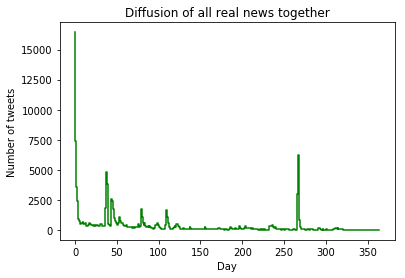

In [5]:
# the longest duration of diffusion among all news headlines 
max_days = max([len(day[coll]) for coll in \
                         [days_col for days_col in day] ])

summ_of_diffusions = [0] * max_days # summary diffusion for every day

# calculate summary diffusion for every day
for d in range(max_days):
    for c in collections:
        # if there is an entry for this day for this collection, add its number of tweets to the number of this day
        if d < len(day[c]): 
            summ_of_diffusions[d] += day[c][d]

plt.step(range(len(summ_of_diffusions)),summ_of_diffusions, 'g')
plt.xlabel('Day') 
plt.ylabel('Number of tweets')
plt.title('Diffusion of all real news together')
plt.show()

# Plot cummulative diffusion of all news together

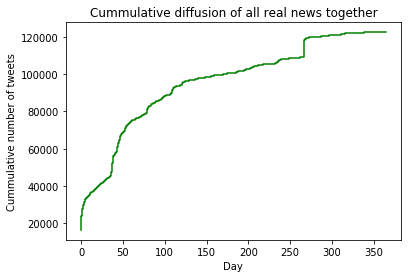

In [6]:
summ_of_diffusions_cumulative = [0] * max_days # 
summ_of_diffusions_cumulative[0] = summ_of_diffusions[0]
for d in range(1, max_days):
    summ_of_diffusions_cumulative[d] += summ_of_diffusions_cumulative[d-1] + summ_of_diffusions[d]

plt.step(range(len(summ_of_diffusions_cumulative)),summ_of_diffusions_cumulative, 'g')
plt.xlabel('Day') 
plt.ylabel('Cummulative number of tweets')
plt.title('Cummulative diffusion of all real news together')
plt.show()

# Plot cummulative diffusion for every news headline

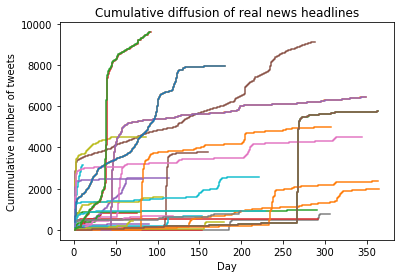

In [7]:
for collection in collections:
    plt.step([d+1 for d in range(len(diff[collection]))], diff[collection])
    
plt.xlabel('Day') 
plt.ylabel('Cummulative number of tweets')
plt.title('Cumulative diffusion of real news headlines')
plt.show()

# Average diffusion per day for all news

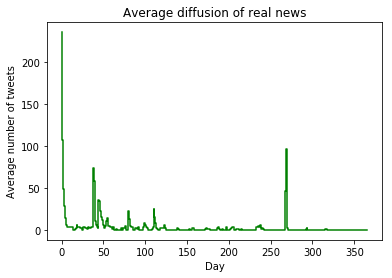

In [8]:
averagediff = [0 for _ in range(max_days)] # average diffusion for every day

for collection in collections:
    for i,d in enumerate(day[collection]):
        averagediff[i] += d / len(collections)

plt.xlabel('Day') 
plt.ylabel('Average number of tweets')
plt.step(range(1,len(averagediff)+1),averagediff, 'g')
plt.title('Average diffusion of real news')
plt.show()

# The same graph but in logarithmic scale

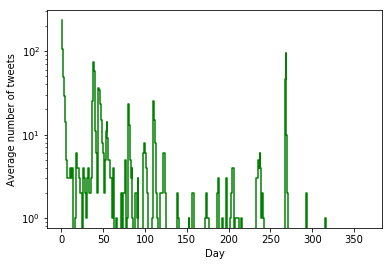

In [9]:
plt.ylabel('Average number of tweets')
plt.xlabel('Day')
plt.yscale('log')
plt.step(range(1,len(averagediff)+1),averagediff, 'g')
plt.show()

# Calculate and plot standart deviation

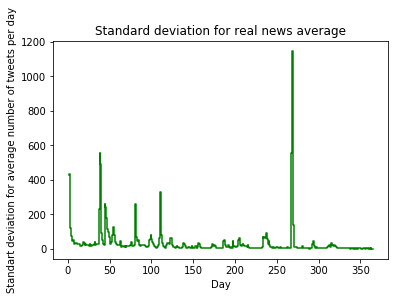

In [10]:
avgdiff_std = [0 for _ in range(max_days)] # standard deviation for every day for all collections
number_tweets = [[] for _ in range(max_days)] # number of tweets for every day for every collection

for d in range(max_days):
    for c in collections:
        # if there is an entry for this day for this collection
        if d < len(day[c]): 
            # add number of tweets for this day for this colletion to the number_tweets for this day 
            number_tweets[d].append(day[c][d])     
    
    # calculate standard deviation for this day
    avgdiff_std[d] = np.std(number_tweets[d])
    
    
plt.ylabel('Standart deviation for average number of tweets per day')
plt.xlabel('Day')
plt.step(range(1,len(avgdiff_std)+1),avgdiff_std, 'g')
plt.title('Standard deviation for real news average')
plt.show()
        

# Calculate and plot share of values inside one standard deviation for every day

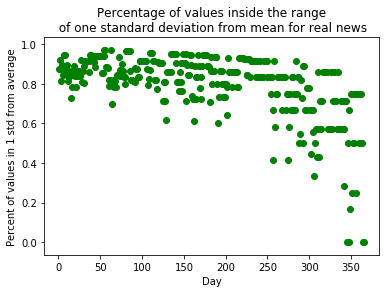

In [11]:
inside_std = [0 for _ in range(max_days)] # number of values inside one standard deviation for every day
inside_std_share = [0 for _ in range(max_days)] # share of values inside one standard deviation for every day

for d in range(max_days):
    for c in collections:
        # set borders of mean plusminus one std
        lowest = averagediff[d] - avgdiff_std[d]
        highest = averagediff[d] + avgdiff_std[d]
        
        # if there is entray for this day for this collection and its value is inside the borderes
        if d < len(day[c]) and (day[c][d] >= lowest and day[c][d] <= highest):
            
            # increment number of values inside one std for this day
            inside_std[d] += 1
    
    # calculate the share of values inside one std for this day
    inside_std_share[d] = inside_std[d] / float(len(number_tweets[d]))
    
plt.ylabel('Percent of values in 1 std from average')
plt.xlabel('Day')
plt.scatter(range(1,len(inside_std_share)+1),inside_std_share, c='g')
plt.title('Percentage of values inside the range\n of one standard deviation from mean for real news')
plt.show()

# Store average diffusion data on hard drive to use by another jupyter notebook

In [15]:

averagediff_real = averagediff
%store averagediff_real

Stored 'averagediff_real' (list)


# Plot average diffusion for both real and fake news on one graph

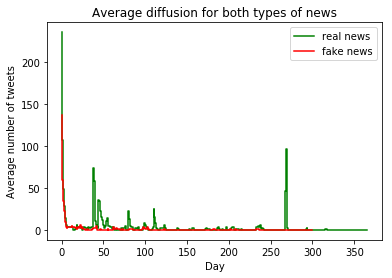

In [16]:
# from hard drive, load data for average diffusion of fake news
%store -r averagediff_fake

plt.xlabel('Day') 
plt.ylabel('Average number of tweets')
plt.step(range(1,len(averagediff)+1),averagediff, 'g', label="real news")
plt.step(range(1,len(averagediff_fake)+1),averagediff_fake, 'r', label="fake news")
plt.legend()
plt.title('Average diffusion for both types of news')
plt.show()

# In logarithmic scale

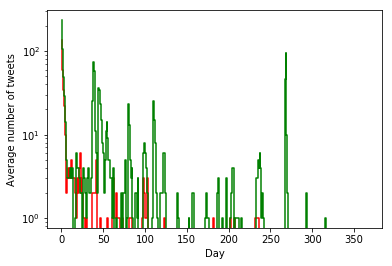

In [17]:
plt.ylabel('Average number of tweets')
plt.xlabel('Day')
plt.yscale('log')
plt.step(range(1,len(averagediff_fake)+1),averagediff_fake, 'r', range(1,len(averagediff)+1),averagediff, 'g')
plt.show()

# Calculate average diffusion duration (number of days until difussion is dead)

In [19]:
diffDurationAvg = 0; # average duration of diffusion

durations  = [len(day[col]) for col in collections] # all durations

diffDurationAvg = np.mean(durations) # mean duration

diffDurationAvg_std = np.std(durations) # standard deviation for the mean
    
print "Average diffusion duration: %.2f days" % diffDurationAvg
print "Standard deviation: %.2f days" % diffDurationAvg_std

Average diffusion duration: 109.78 days
Standard deviation: 125.51 days
